In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('dataset/ner_dataset.csv', encoding='latin1')

In [3]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
# filling null values in Sentence # column
data = data.fillna(method='ffill')

In [5]:
# # filtering sentences
# def getSentenceId(num_sentences=10000):
#     ids = []
#     for i in range(num_sentences):
#         ids.append(f'Sentence: {i+1}')
#     return ids

# data = data.loc[data['Sentence #'].isin(getSentenceId())]

In [6]:
# shape of the data
data.shape

(1048575, 4)

In [7]:
# number of unique words
words = list(set(data['Word'].values))
num_words = len(words)
print(f'Number of words = {num_words}')

Number of words = 35177


In [8]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)
print(f"Number of tags = {num_tags}")

Number of tags = 17


In [9]:
# occurrences of tags in sentences
data['Tag'].value_counts()

Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

In [10]:
# creating a class to create sentences given a dataset

class sentenceGetter(object):

    def __init__(self, data):

        # assigning data to class attribute
        self.data = data

        # defining a function to extract sentences in the given format from the data
        agg_func = lambda s: [(w,p,t) for w,p,t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]

        # applying this function to each sentence group
        self.grouped = self.data.groupby(['Sentence #']).apply(agg_func)
        self.sentences = [s for s in self.grouped]


# getting all the sentences from the data
getter = sentenceGetter(data)
sentences = getter.sentences

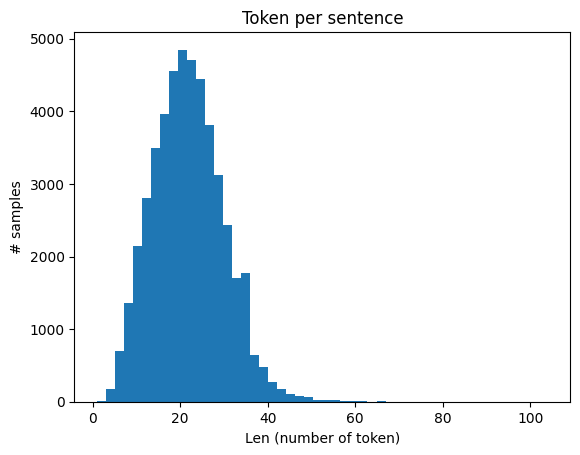

In [11]:
# Plot sentence by length
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [12]:
# creating word tokens

# word to token dict
word2idx = {w:i+2 for i,w in enumerate(words)}
word2idx['PAD'] = 0
word2idx['UNK'] = 1

# token to word dict
idx2word = {i:w for w,i in word2idx.items()}

In [13]:
# creating tag tokens

# tag to token dict
tag2idx = {t:i+1 for i,t in enumerate(tags)}
tag2idx['PAD'] = 0

# token to tag dict
idx2tag = {i:t for t,i in tag2idx.items()}

In [14]:
# creating the x and y data by replacing the words with tokens and padding the sequence
from tensorflow.keras.utils import pad_sequences

x = [[word2idx[w[0]] for w in s] for s in sentences]
x = pad_sequences(x, maxlen=75, padding='post', value=word2idx['PAD'])

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(y, maxlen=75, padding='post', value=tag2idx['PAD'])

In [15]:
# converting the tags to one hot encoding
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)


In [16]:
# splitting the data into train and test
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(np.asarray(x), np.asarray(y), test_size=0.2, random_state=21)

In [17]:
# checking sentences and tags before and after convertion

print('Raw sentence')
print(f"{' '.join([w[0] for w in sentences[0]])} \n")

print('Raw tags')
print(f"{' '.join([w[2] for w in sentences[0]])} \n")

print('Converted sentence')
print(f"{x[0]} \n")

print('Converted tag')
print(f"{y[0]}")

Raw sentence
Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . 

Raw tags
O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O 

Converted sentence
[10687 11544 22105 29221  5044  1983 19863 10679 16557 11127 13122  7383
  4784 15232  1541 11127  6265 11544 23462 17018 18524  6640 30776 24304
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0] 

Converted tag
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## Modelling (bi-LSTM + CRF)

In [18]:
!pip install tensorflow-addons

In [19]:
# importing layers
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

In [20]:
maxlen = 75
word_dims = len(words)+2
embedding_dims = 200
label_length = len(tags)+1

In [44]:
def build_model(maxlen=maxlen, input_dim=word_dims, embedding_dims=embedding_dims, label_length=label_length):
    
    # defining input
    input = Input(shape=(maxlen,), name='input')
    
    # get embeddings
    embeddings = Embedding(
        input_dim=input_dim,
        output_dim=embedding_dims,
        mask_zero=True,
        name='embedding'
    )(input)
    
    # passing the embeddings to stacked bi-LSTMs
    output_sequences = Bidirectional(LSTM(50, return_sequences=True), name='lstm_1')(embeddings)
    output_sequences = Bidirectional(LSTM(50, return_sequences=True), name='lstm_2')(output_sequences)
    
    # applying dense units for data compressions
    dense_output = TimeDistributed(Dense(25, activation='relu'), name='dense')(output_sequences)
    
    # applying the CRF layer to dense output
    predicted_sequence, potentials, sequence_length, crf_kernel = CRF(label_length, name='crf')(dense_output)
    
    # defining the model
    model = Model(input,potentials)
    
    # compiling the model
    model.compile(
        loss=SigmoidFocalCrossEntropy(),
        optimizer='adam'
    )
    
    # return the model
    return model

In [45]:
model = build_model()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 75)]              0         
                                                                 
 embedding (Embedding)       (None, 75, 200)           7035800   
                                                                 
 lstm_1 (Bidirectional)      (None, 75, 100)           100400    
                                                                 
 lstm_2 (Bidirectional)      (None, 75, 100)           60400     
                                                                 
 dense (TimeDistributed)     (None, 75, 25)            2525      
                                                                 
 crf (CRF)                   [(None, 75),              828       
                              (None, 75, 18),                    
                              (None,),                     

In [27]:
# callbacks
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='ner_crf.h5',
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

callbacks = [save_model, es]

In [28]:
history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), callbacks=callbacks, epochs=50, batch_size=1024)

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.8442
Epoch 1: val_loss improved from inf to 0.54554, saving model to ner_crf.h5
38/38 [==============================] - 64s 1s/step - loss: 0.8442 - val_loss: 0.5455
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.4772
Epoch 2: val_loss improved from 0.54554 to 0.40480, saving model to ner_crf.h5
38/38 [==============================] - 47s 1s/step - loss: 0.4772 - val_loss: 0.4048
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.3589
Epoch 3: val_loss improved from 0.40480 to 0.31667, saving model to ner_crf.h5
38/38 [==============================] - 49s 1s/step - loss: 0.3589 - val_loss: 0.3167
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 0.2847
Epoch 4: val_loss improved from 0.31667 to 0.25225, saving model to ner_crf.h5
38/38 [==============================] - 50s 1s/step - loss: 0.2847 - val_loss: 0.2522
Epoch 5/50
38/38 [======================

In [38]:
# loading trained weights
model.load_weights('ner_crf.h5')

In [43]:
# eval_model
model.get_layer('input')

In [46]:
# eval_model
def build_eval_model(model):
    
    # intermediate model
    int_model = Model(model.get_layer('input').input,model.get_layer('dense').output)
    
    # getting output from the crf layer
    predicted_sequence, potentials, sequence_length, crf_kernel = model.get_layer('crf')(int_model.output)
    
    # defining evaluation model
    eval_model = Model(int_model.input, predicted_sequence)
    
    return eval_model

In [48]:
eval_model = build_eval_model(model)
ypred = eval_model.predict(xtest)

In [56]:
np.random.choice(range(xtest.shape[0]), 1)

array([3411])

In [59]:
np.count_nonzero(np.array([1,2,2,2,3,4,5,0,0,0,0,0,0,0,0,0,0]))

7

In [60]:
' '.join(('1','2','3'))

'1 2 3'

In [63]:
# checking the predictions
def check_prediction(n=1):
    
    # getting a random text from the test data
    idx = np.random.choice(range(xtest.shape[0]), n, replace=False)
    
    for i in idx:
        
        sentence = xtest[i]
        tags = np.argmax(ytest[i],axis=-1)
        pred = ypred[i]
        text_len = np.count_nonzero(sentence)
        
        sentence = sentence[:text_len]
        tags = tags[:text_len]
        pred = pred[:text_len]
        
        sentence = [idx2word[t] for t in sentence]
        tags = [idx2tag[t] for t in tags]
        pred = [idx2tag[t] for t in pred]

        print(f"Sentence {i}")
        print("Word | Actual tag | Predicted tag")
        print("-"*30)
        for j in zip(sentence,tags,pred):
            print(f"{' | '.join(j)}")
    pass

In [64]:
check_prediction()

Sentence 1475
Word | Actual tag | Predicted tag
------------------------------
She | O | I-gpe
said | O | B-art
she | O | I-per
would | O | PAD
seek | O | O
charges | O | B-tim
of | O | I-gpe
betrayal | O | B-art
of | O | I-per
national | O | PAD
interests | O | O
and | O | B-tim
exceeding | O | I-gpe
authority | O | B-art
. | O | I-per
